# pop_bilateral filter with just in time compilation and nogil
Benchmark of scikit-image's pop_bilateral filter (rank cython) vs python jit with numba. 

Numba also allows for easy multiprocessing with releasing the global intepreter lock.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import rank
from skimage.morphology import square

### parallel processing with dask and threading
For more details, see https://github.com/scikit-image/scikit-image/pull/1493

In [29]:
from math import ceil
from multiprocessing import cpu_count
import dask.array as da

def _get_chunks(shape, ncpu):
    chunks = []
    nchunks_per_dim = int(ceil(ncpu ** (1./len(shape))))

    used_chunks = 1
    for i in shape:
        if used_chunks < ncpu:
            regular_chunk = i // nchunks_per_dim
            remainder_chunk = regular_chunk + (i % nchunks_per_dim)

            if regular_chunk == 0:
                chunk_lens = (remainder_chunk,)
            else:
                chunk_lens = ((regular_chunk,) * (nchunks_per_dim - 1) +
                              (remainder_chunk,))
        else:
            chunk_lens = (i,)

        chunks.append(chunk_lens)
        used_chunks *= nchunks_per_dim
    return tuple(chunks)


def apply_chunks(function, array, chunks=None, depth=0, mode=None,
                 extra_arguments=(), extra_keywords={}):
    if chunks is None:
        shape = array.shape
        ncpu = cpu_count()
        chunks = _get_chunks(shape, ncpu)

    if mode == 'wrap':
        mode = 'periodic'

    def wrapped_func(arr):
        return function(arr, *extra_arguments, **extra_keywords)

    darr = da.from_array(array, chunks=chunks)
    return darr.map_overlap(wrapped_func, depth, boundary=mode).compute()

### numba population bilateral

In [30]:
def pop_bilateral(img, selem, s0=10, s1=10):
    """Simple pop bilateral filter.
    
    Parameters
    ----------
    img : 2d array
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    img = img.astype(np.int16) # avoid overrun when calculating diff
    pad = selem.shape[0]//2 # square selem for now
    selem_size = 2*pad+1 # always center in center
    out = np.zeros(img.shape, dtype=np.uint8) # nopython, nogil
    img = np.pad(img, pad, mode='edge') # nopython, nogil
    _pop_bilateral(img, selem_size, out, s0, s1)
    return out

@jit(nogil=True, nopython=True)
def _pop_bilateral(img, selem_size, out, s0=10, s1=10):
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            val = img[i+pad, j+pad]
            o = 0
            for ii in range(selem_size):
                for jj in range(selem_size):
                    diff = img[i+ii, j+jj] - val
                    if diff >= -s0 and diff <= s1:
                        o += 1
            out[i, j] = o # cheaper than accessing array in each inner loop

### numba mean

In [36]:
def mean(img, selem):
    """Simple mean filter.
    
    Parameters
    ----------
    img : 2d array
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    """
    img = img.astype(np.uint32)
    out = np.empty(img.shape, dtype=np.uint8)
    pad = selem.shape[0]//2 # square selem for now
    img = np.pad(img, pad, mode='edge')
    rows = np.zeros(img.shape, dtype=np.uint32) # size of padded
    selem_size = 2*pad+1
    _mean(img, selem_size, rows, out)
    return out


@jit(nopython=True, nogil=True)
def _mean(img, selem_size, rows, out):
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix):
            for ii in range(selem_size):
                rows[i, j] += img[i+ii, j]
    # 2n instead of 2^2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            o = 0
            for jj in range(selem_size):
                o += rows[i, j+jj]
            out[i, j] = o // selem_size**2

45 Mega pixels


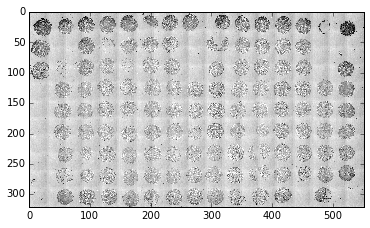

In [28]:
img = imread('data/experiment--2015_05_04_19_28_38_equalized/stitched--U00--V00--C00--Z00.png')
imshow(img[::16, ::16])
mpixels = int(img.shape[0] * img.shape[1] * 1e-6)
print(mpixels, 'Mega pixels')

### pop speed comparison

In [42]:
# skimage
%time pop_sk = rank.pop_bilateral(img, square(21))

CPU times: user 32.6 s, sys: 569 ms, total: 33.1 s
Wall time: 33.6 s


In [32]:
# numba
%time pop_nb = pop_bilateral(img, square(21))

CPU times: user 14.1 s, sys: 387 ms, total: 14.5 s
Wall time: 14.5 s


In [33]:
# numba parallel with dask threading
%time pop_da = apply_chunks(pop_bilateral, img, depth=4, extra_arguments=(square(9),))

CPU times: user 23.7 s, sys: 704 ms, total: 24.4 s
Wall time: 6.76 s


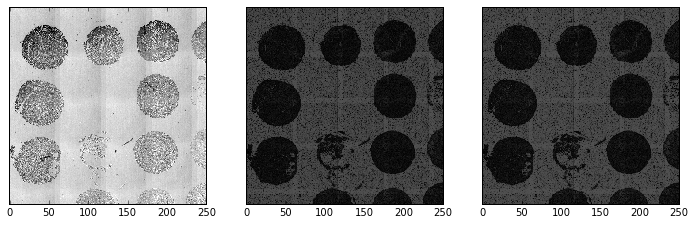

In [41]:
plt.figure(figsize=(12,4))
mask = np.index_exp[:2000:8, :2000:8]
plt.subplot(131)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(132)
imshow(pop_sk[mask]).axes.set_yticks([])
plt.subplot(133)
imshow(pop_nb[mask]).axes.set_yticks([]);

### mean speed comparison

In [37]:
# skimage
%time mean_sk = rank.mean(img, square(9))

CPU times: user 13.6 s, sys: 221 ms, total: 13.8 s
Wall time: 13.9 s


In [38]:
# numba mean
%time mean_nb = mean(img, square(9))

CPU times: user 3.49 s, sys: 743 ms, total: 4.24 s
Wall time: 4.24 s


In [39]:
# numba parallel with dask threading
%time mean_da = apply_chunks(mean, img, depth=4, extra_arguments=(square(9),))

CPU times: user 4.83 s, sys: 1.51 s, total: 6.34 s
Wall time: 2.36 s


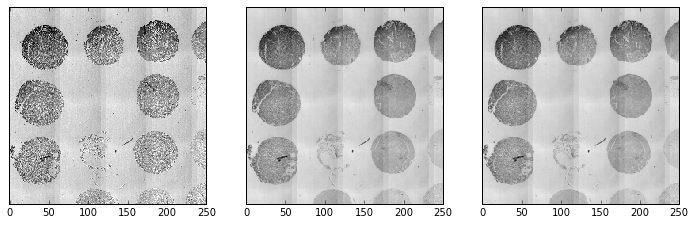

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(131)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(132)
imshow(mean_sk[mask]).axes.set_yticks([])
plt.subplot(133)
imshow(mean_nb[mask]).axes.set_yticks([]);

### debug numba

In [35]:
_pop_bilateral.inspect_types()

_pop_bilateral (array(int16, 2d, C), int64, array(uint8, 2d, C), int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-30-aac85b6a256f>
# --- LINE 23 --- 

@jit(nogil=True, nopython=True)

# --- LINE 24 --- 

def _pop_bilateral(img, selem_size, out, s0=10, s1=10):

    # --- LINE 25 --- 

    """

    # --- LINE 26 --- 

    Parameters

    # --- LINE 27 --- 

    ----------

    # --- LINE 28 --- 

    img : 2d array

        # --- LINE 29 --- 

        Padded image.

    # --- LINE 30 --- 

    selem_size : int

        # --- LINE 31 --- 

        Size of square selem.

    # --- LINE 32 --- 

    out : 2d array

        # --- LINE 33 --- 

        Array to store result to (nopython, nogil).

    # --- LINE 34 --- 

    s0 : int

        # --- LINE 35 --- 

        Lower bound.

    # --- LINE 36 --- 

    s1 : int

        # --- LINE 37 --- 

        Higher bound.

    # --- LINE 38 --- 

    """

    # --- LINE 39 --- 